In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd

pd.read_csv("./multi_gauge_predict.csv")["NSE"].median()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.1367644774044037

### Imports

In [2]:
import pathlib
from functools import reduce
from copy import deepcopy
from typing import List, Union
import warnings
import logging

import torch
import pandas as pd
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.models import TFTModel
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", ".*does not have many workers.*")
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
torch.set_float32_matmul_precision("medium")


from scripts.metric_definers import metric_df
from scripts.tft_data_creators import (
    LossLogger,
    covariate_creator,
    target_creator,
    type32_converter,
    scale_with_static,
)

loss_logger = LossLogger()

# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")


meteo_input = ["prcp_e5l", "t_max_e5l", "t_min_e5l"]
# q_mm_day or lvl_sm
hydro_target = "q_mm_day"

if (hydro_target == "lvl_mbs") | (hydro_target == "lvl_sm"):
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "sgr_dk_sav",
        "slp_dg_sav",
        "ws_area",
        "ele_mt_sav",
        "height_bs",
    ]
    nc_variable = "nc_all_h"
else:
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "sgr_dk_sav",
        "slp_dg_sav",
        "ws_area",
        "ele_mt_sav",
    ]
    nc_variable = "nc_all_q"

gauges = list(i.stem for i in pathlib.Path("./model/single_gauge").glob("./*"))

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
input_chunk_length = 365
output_chunk_length = 7

train_start = "2008-01-01"
train_end = "2016-12-31"

val_start = pd.to_datetime("2017-01-01")
val_end = pd.to_datetime("2018-12-31")

pred_start = pd.to_datetime("2019-01-01") - pd.to_timedelta(f"{input_chunk_length}D")
pred_end = "2020-12-31"

pred_start = pd.to_datetime("2019-01-01") - pd.to_timedelta(f"{input_chunk_length}D")
pred_end = "2020-12-31"

with_static = True
index_col = "gauge_id"
static_path = "../geo_data/attributes/static_with_height.csv"
nc_files = list(
    pathlib.Path(f"../geo_data/ws_related_meteo/{nc_variable}").glob("./*.nc")
)

if with_static:
    static_attributes = pd.read_csv(static_path, index_col=index_col)
    static_attributes.index = static_attributes.index.astype(str)
    static_attributes = static_attributes.replace(np.NaN, 0.0)
else:
    static_attributes = None

In [ ]:
tft_single_gauge_stat = list()

for gauge_id in tqdm(gauges):
    tft_model = TFTModel.load_from_checkpoint(
        model_name="q_mm_day_hs256_bs256_do042",
        work_dir=f"./model/single_gauge/{gauge_id}",
    )

    if isinstance(static_attributes, pd.DataFrame):
        static_attributes = static_attributes[[*static_parameters]]
        gauge_static = static_attributes.loc[[gauge_id], :]
    else:
        gauge_static = None
    with xr.open_dataset(
        f"../geo_data/ws_related_meteo/{nc_variable}/{gauge_id}.nc"
    ) as f:
        gauge_file = f.to_dataframe()
    gauge_file = gauge_file[[*meteo_input, hydro_target, "gauge_id"]]

    if isinstance(gauge_static, pd.DataFrame):
        for col in gauge_static.columns:
            gauge_file[col] = gauge_static.loc[gauge_id, col]

    past_df = gauge_file[:train_end].reset_index(drop=False)
    future_df = gauge_file[:val_end].reset_index(drop=False)
    val_past_df = gauge_file[val_start:val_end].reset_index(drop=False)
    val_future_df = gauge_file[val_start:val_end].reset_index(drop=False)
    pred_df = gauge_file[pred_start:pred_end].reset_index(drop=False)

    # create timeseries and scaler
    train_target_scaler, train_cov_scaler, train_static_scaler = (
        Scaler(scaler=StandardScaler()),
        Scaler(scaler=StandardScaler()),
        StaticCovariatesTransformer(),
    )
    # train
    train_target = target_creator(
        data_frame=past_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    past_cov = covariate_creator(
        data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
    )
    future_cov = covariate_creator(
        data_frame=future_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    # val
    val_target = target_creator(
        data_frame=val_past_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    # val_plot = target_creator(
    #     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
    val_past_cov = covariate_creator(
        data_frame=val_past_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    val_future_cov = covariate_creator(
        data_frame=val_future_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    # pred
    pred_target = target_creator(
        data_frame=pred_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    pred_cov = covariate_creator(
        data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
    )

    # scale target
    train_target = train_target_scaler.fit_transform(train_target)
    train_target = train_static_scaler.fit_transform(train_target)
    train_target = type32_converter(train_target)
    # scale covariate
    past_cov = train_cov_scaler.fit_transform(past_cov)
    past_cov = train_static_scaler.transform(past_cov)
    past_cov = type32_converter(past_cov)
    # prepare new data
    future_cov = scale_with_static(
        series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )
    # val
    val_target = scale_with_static(
        series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
    )
    val_past_cov = scale_with_static(
        series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )
    val_future_cov = scale_with_static(
        series=val_future_cov,
        scaler=train_cov_scaler,
        static_scaler=train_static_scaler,
    )
    # pred
    pred_target = scale_with_static(
        series=pred_target,
        scaler=train_target_scaler,
        static_scaler=train_static_scaler,
    )
    pred_cov = scale_with_static(
        series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )

    gauge_prediction = tft_model.historical_forecasts(
        num_samples=1,
        series=pred_target[0],
        past_covariates=pred_cov[0],
        future_covariates=pred_cov[0],
        retrain=False,
        verbose=False,
    )

    res_df = pd.DataFrame()

    res_df["date"] = pd.date_range(
        start="2019-01-01",
        end=pd.to_datetime("2021-01-01") - pd.Timedelta(f"{output_chunk_length}D"),
    )
    res_df["pred"] = (
        train_target_scaler.inverse_transform(gauge_prediction).values().squeeze()
    )
    res_df["obs"] = (
        train_target_scaler.inverse_transform(
            pred_target[0][input_chunk_length : -(output_chunk_length - 1)]
        )
        .values()
        .squeeze()
    )
    res_df = res_df.set_index("date")

    # res_df[["pred", "obs"]].plot()
    tft_single_gauge_stat.append(
        metric_df(gauge_id=gauge_id, predictions=res_df["pred"], targets=res_df["obs"])
    )
    tft_model = None

In [27]:
gauge_id = gauges[0]

tft_model = TFTModel.load_from_checkpoint(
    model_name="q_mm_day_hs256_bs256_do042",
    work_dir=f"./model/single_gauge/{gauge_id}",
)

if isinstance(static_attributes, pd.DataFrame):
    static_attributes = static_attributes[[*static_parameters]]
    gauge_static = static_attributes.loc[[gauge_id], :]
else:
    gauge_static = None
with xr.open_dataset(f"../geo_data/ws_related_meteo/{nc_variable}/{gauge_id}.nc") as f:
    gauge_file = f.to_dataframe()
gauge_file = gauge_file[[*meteo_input, hydro_target, "gauge_id"]]

if isinstance(gauge_static, pd.DataFrame):
    for col in gauge_static.columns:
        gauge_file[col] = gauge_static.loc[gauge_id, col]

past_df = gauge_file[:train_end].reset_index(drop=False)
future_df = gauge_file[:val_end].reset_index(drop=False)
val_past_df = gauge_file[val_start:val_end].reset_index(drop=False)
val_future_df = gauge_file[val_start:val_end].reset_index(drop=False)
pred_df = gauge_file[pred_start:pred_end].reset_index(drop=False)

# create timeseries and scaler
train_target_scaler, train_cov_scaler, train_static_scaler = (
    Scaler(scaler=StandardScaler()),
    Scaler(scaler=StandardScaler()),
    StaticCovariatesTransformer(),
)
# train
train_target = target_creator(
    data_frame=past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
past_cov = covariate_creator(
    data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
)
future_cov = covariate_creator(
    data_frame=future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# val
val_target = target_creator(
    data_frame=val_past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
# val_plot = target_creator(
#     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
val_past_cov = covariate_creator(
    data_frame=val_past_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
val_future_cov = covariate_creator(
    data_frame=val_future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# pred
pred_target = target_creator(
    data_frame=pred_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
pred_cov = covariate_creator(
    data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
)


def type32_converter(
    series_list: TimeSeries | list[TimeSeries],
) -> list[TimeSeries]:
    return [s.astype(dtype="float32") for s in series_list]


def scale_with_static(
    series: TimeSeries | list[TimeSeries],
    scaler: Scaler,
    static_scaler: StaticCovariatesTransformer,
) -> list[TimeSeries]:
    series = scaler.transform(series=series)
    series = static_scaler.transform(series=series)

    return type32_converter(series_list=series)


# scale target
train_target = train_target_scaler.fit_transform(train_target)
train_target = train_static_scaler.fit_transform(train_target)
train_target = type32_converter(train_target)
# scale covariate
past_cov = train_cov_scaler.fit_transform(past_cov)
past_cov = train_static_scaler.transform(past_cov)
past_cov = type32_converter(past_cov)
# prepare new data
future_cov = scale_with_static(
    series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
# val
val_target = scale_with_static(
    series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
)
val_past_cov = scale_with_static(
    series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
val_future_cov = scale_with_static(
    series=val_future_cov,
    scaler=train_cov_scaler,
    static_scaler=train_static_scaler,
)
# pred
pred_target = scale_with_static(
    series=pred_target,
    scaler=train_target_scaler,
    static_scaler=train_static_scaler,
)
pred_cov = scale_with_static(
    series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)

gauge_prediction = tft_model.historical_forecasts(
    num_samples=1,
    series=pred_target[0],
    past_covariates=pred_cov[0],
    future_covariates=pred_cov[0],
    retrain=False,
    verbose=False,
)

res_df = pd.DataFrame()

res_df["date"] = pd.date_range(
    start="2019-01-01",
    end=pd.to_datetime("2021-01-01") - pd.Timedelta(f"{output_chunk_length}D"),
)
res_df["pred"] = (
    train_target_scaler.inverse_transform(gauge_prediction).values().squeeze()
)
res_df["obs"] = (
    train_target_scaler.inverse_transform(
        pred_target[0][input_chunk_length : -(output_chunk_length - 1)]
    )
    .values()
    .squeeze()
)
res_df = res_df.set_index("date")
tft_model = None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


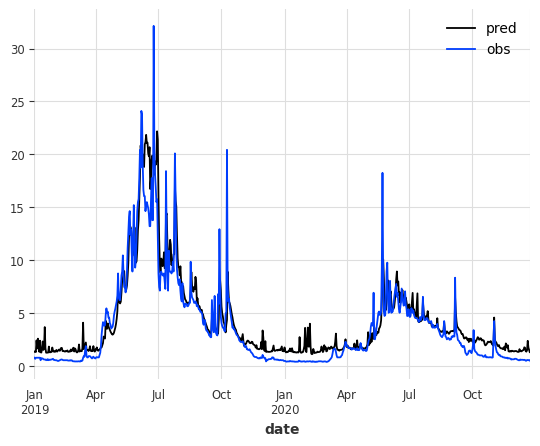

In [28]:
res_df.plot();

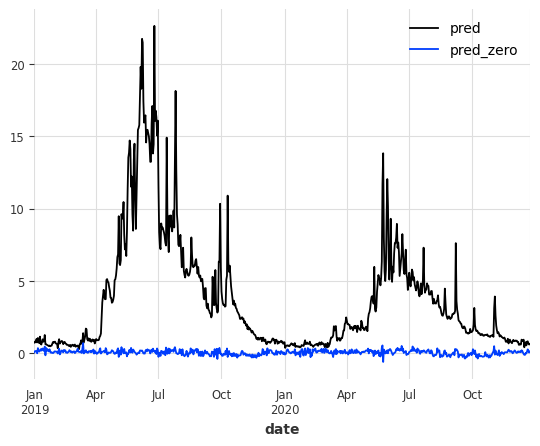

In [26]:
from copy import deepcopy

tft_model = TFTModel.load_from_checkpoint(
    model_name="q_mm_day_hs256_bs256_do042",
    work_dir=f"./model/single_gauge/{gauges[0]}",
)


if isinstance(static_attributes, pd.DataFrame):
    static_attributes = static_attributes[[*static_parameters]]
    gauge_static = static_attributes.loc[[gauge_id], :]
else:
    gauge_static = None
with xr.open_dataset(f"../geo_data/ws_related_meteo/{nc_variable}/{gauge_id}.nc") as f:
    gauge_file = f.to_dataframe()
gauge_file = gauge_file[[*meteo_input, hydro_target, "gauge_id"]]

if isinstance(gauge_static, pd.DataFrame):
    for col in gauge_static.columns:
        gauge_file[col] = gauge_static.loc[gauge_id, col]

past_df = gauge_file[:train_end].reset_index(drop=False)
future_df = gauge_file[:val_end].reset_index(drop=False)
val_past_df = gauge_file[val_start:val_end].reset_index(drop=False)
val_future_df = gauge_file[val_start:val_end].reset_index(drop=False)
pred_df = gauge_file[pred_start:pred_end].reset_index(drop=False)
pred_df_zero = deepcopy(pred_df)
pred_df_zero[f"{hydro_target}"] = 0

# create timeseries and scaler
train_target_scaler, train_cov_scaler, train_static_scaler = (
    Scaler(scaler=StandardScaler()),
    Scaler(scaler=StandardScaler()),
    StaticCovariatesTransformer(),
)
# train
train_target = target_creator(
    data_frame=past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
past_cov = covariate_creator(
    data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
)
future_cov = covariate_creator(
    data_frame=future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# val
val_target = target_creator(
    data_frame=val_past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
# val_plot = target_creator(
#     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
val_past_cov = covariate_creator(
    data_frame=val_past_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
val_future_cov = covariate_creator(
    data_frame=val_future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# pred
pred_target = target_creator(
    data_frame=pred_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
pred_target_zero = target_creator(
    data_frame=pred_df_zero,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
pred_cov = covariate_creator(
    data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
)


def type32_converter(
    series_list: TimeSeries | list[TimeSeries],
) -> list[TimeSeries]:
    return [s.astype(dtype="float32") for s in series_list]


def scale_with_static(
    series: TimeSeries | list[TimeSeries],
    scaler: Scaler,
    static_scaler: StaticCovariatesTransformer,
) -> list[TimeSeries]:
    series = scaler.transform(series=series)
    series = static_scaler.transform(series=series)

    return type32_converter(series_list=series)


# scale target
train_target = train_target_scaler.fit_transform(train_target)
train_target = train_static_scaler.fit_transform(train_target)
train_target = type32_converter(train_target)
# scale covariate
past_cov = train_cov_scaler.fit_transform(past_cov)
past_cov = train_static_scaler.transform(past_cov)
past_cov = type32_converter(past_cov)
# prepare new data
future_cov = scale_with_static(
    series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
# val
val_target = scale_with_static(
    series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
)
val_past_cov = scale_with_static(
    series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
val_future_cov = scale_with_static(
    series=val_future_cov,
    scaler=train_cov_scaler,
    static_scaler=train_static_scaler,
)
# pred
pred_target = scale_with_static(
    series=pred_target,
    scaler=train_target_scaler,
    static_scaler=train_static_scaler,
)
pred_target_zero = scale_with_static(
    series=pred_target_zero,
    scaler=train_target_scaler,
    static_scaler=train_static_scaler,
)
pred_cov = scale_with_static(
    series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)

gauge_prediction = tft_model.historical_forecasts(
    num_samples=1,
    series=pred_target[0],
    past_covariates=pred_cov[0],
    future_covariates=pred_cov[0],
    retrain=False,
    verbose=False,
)
gauge_prediction_zero = tft_model.historical_forecasts(
    num_samples=1,
    series=pred_target_zero[0],
    past_covariates=pred_cov[0],
    future_covariates=pred_cov[0],
    retrain=False,
    verbose=False,
)

res_df = pd.DataFrame()

res_df["date"] = pd.date_range(
    start="2019-01-01",
    end=pd.to_datetime("2021-01-01") - pd.Timedelta(f"{output_chunk_length}D"),
)
res_df["pred"] = (
    train_target_scaler.inverse_transform(gauge_prediction).values().squeeze()
)
res_df["pred_zero"] = (
    train_target_scaler.inverse_transform(gauge_prediction_zero).values().squeeze()
)
res_df["obs"] = (
    train_target_scaler.inverse_transform(
        pred_target[0][input_chunk_length : -(output_chunk_length - 1)]
    )
    .values()
    .squeeze()
)
res_df = res_df.set_index("date")


metric_df(gauge_id=gauge_id, predictions=res_df["pred"], targets=res_df["obs"])
res_df[["pred", "pred_zero"]].plot();

In [95]:
from copy import deepcopy

test_ = deepcopy(res_df[["pred"]])

In [ ]:
some_pred = tft_model.predict(
    n=output_chunk_length,
    series=pred_target[0][: -(output_chunk_length + 0)],
    past_covariates=pred_cov[0][: -(output_chunk_length + 0)],
    future_covariates=pred_cov[0][-(input_chunk_length + output_chunk_length + 0) :],
    verbose=True,
)
pred_df = pd.DataFrame()
pred_df.index = some_pred.time_index
pred_df["pred"] = train_target_scaler.inverse_transform(some_pred).values().squeeze()

In [ ]:
from tqdm.notebook import tqdm

tft_single_gauge_stat = list()

for gauge_id in tqdm(gauges, desc="I'm Scatman !"):
    


### !TODO

In [45]:
gauge_id = gauges[0]

# tft_model = TFTModel.load_from_checkpoint(
#     model_name="q_mm_day_hs256_bs256_do042",
#     work_dir=f"./model/single_gauge/{gauge_id}",
# )
tft_model = TFTModel.load_from_checkpoint(
    model_name="q_mm_day_hs256_bs128_do042",
    work_dir="./model",
)

if isinstance(static_attributes, pd.DataFrame):
    static_attributes = static_attributes[[*static_parameters]]
    gauge_static = static_attributes.loc[[gauge_id], :]
else:
    gauge_static = None
with xr.open_dataset(f"../geo_data/ws_related_meteo/{nc_variable}/{gauge_id}.nc") as f:
    gauge_file = f.to_dataframe()
gauge_file = gauge_file[[*meteo_input, hydro_target, "gauge_id"]]

if isinstance(gauge_static, pd.DataFrame):
    for col in gauge_static.columns:
        gauge_file[col] = gauge_static.loc[gauge_id, col]

past_df = gauge_file[:train_end].reset_index(drop=False)
future_df = gauge_file[:val_end].reset_index(drop=False)
val_past_df = gauge_file[val_start:val_end].reset_index(drop=False)
val_future_df = gauge_file[val_start:val_end].reset_index(drop=False)
pred_df = gauge_file[train_start:pred_end].reset_index(drop=False)

# create timeseries and scaler
train_target_scaler, train_cov_scaler, train_static_scaler = (
    Scaler(scaler=StandardScaler()),
    Scaler(scaler=StandardScaler()),
    StaticCovariatesTransformer(),
)
# train
train_target = target_creator(
    data_frame=past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
past_cov = covariate_creator(
    data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
)
future_cov = covariate_creator(
    data_frame=future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# val
val_target = target_creator(
    data_frame=val_past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
# val_plot = target_creator(
#     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
val_past_cov = covariate_creator(
    data_frame=val_past_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
val_future_cov = covariate_creator(
    data_frame=val_future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# pred
# pred_target = target_creator(
#     data_frame=pred_df,
#     target_input=hydro_target,
#     static_parameters=static_parameters,
# )
# pred_cov = covariate_creator(
#     data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
# )

# scale target
train_target = train_target_scaler.fit_transform(train_target)
train_target = train_static_scaler.fit_transform(train_target)
train_target = type32_converter(train_target)
# scale covariate
past_cov = train_cov_scaler.fit_transform(past_cov)
past_cov = train_static_scaler.transform(past_cov)
past_cov = type32_converter(past_cov)
# prepare new data
future_cov = scale_with_static(
    series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
# val
val_target = scale_with_static(
    series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
)
val_past_cov = scale_with_static(
    series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
val_future_cov = scale_with_static(
    series=val_future_cov,
    scaler=train_cov_scaler,
    static_scaler=train_static_scaler,
)
# pred
# pred_target = scale_with_static(
#     series=pred_target,
#     scaler=train_target_scaler,
#     static_scaler=train_static_scaler,
# )
# pred_cov = scale_with_static(
#     series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
# )

pred_len = pd.date_range(start=pred_start, end=pred_end).__len__()

test_pred = list()

target_index_col = pred_df.columns.get_loc(f"{hydro_target}")

target_obs = deepcopy(pred_df).iloc[
    -(pred_len - input_chunk_length) :, target_index_col
]

for i in tqdm(range(0, (pred_len - input_chunk_length - output_chunk_length) + 1)):
    slice_limit = -pred_len + input_chunk_length + output_chunk_length + i

    if slice_limit == 0:
        pred_step_df = pred_df.iloc[:, :]
    else:
        pred_step_df = pred_df.iloc[:slice_limit, :]
    # pred
    pred_target = scale_with_static(
        series=target_creator(
            # data_frame=pred_df.iloc[: (-pred_len + input_chunk_length + i), :],
            data_frame=pred_step_df.iloc[:(-output_chunk_length), :],
            target_input=hydro_target,
            static_parameters=static_parameters,
        ),
        scaler=train_target_scaler,
        static_scaler=train_static_scaler,
    )
    pred_cov = scale_with_static(
        series=covariate_creator(
            # data_frame=pred_df.iloc[
            #     : (-pred_len + input_chunk_length + i), :
            # ],
            data_frame=pred_step_df.iloc[:(-output_chunk_length), :],
            static_parameters=static_parameters,
            meteo_input=meteo_input,
        ),
        scaler=train_cov_scaler,
        static_scaler=train_static_scaler,
    )

    pred_cov_future = scale_with_static(
        series=covariate_creator(
            data_frame=pred_step_df,
            static_parameters=static_parameters,
            meteo_input=meteo_input,
        ),
        scaler=train_cov_scaler,
        static_scaler=train_static_scaler,
    )

    some_pred = tft_model.predict(
        n=output_chunk_length,
        series=pred_target,
        past_covariates=pred_cov,
        future_covariates=pred_cov_future,
        verbose=False,
        num_loader_workers=15,
        num_samples=10,
    )

    temp_df = pd.DataFrame()
    temp_df["date"] = some_pred[0].time_index
    temp_df = temp_df.set_index("date")

    temp_df[f"{hydro_target}"] = (
        train_target_scaler.inverse_transform(some_pred[0]).values().squeeze()
    )
    test_pred.append(temp_df)

    if slice_limit == 0:
        pred_df.iloc[
            -(pred_len - input_chunk_length - i) :,
            target_index_col,
        ] = train_target_scaler.inverse_transform(some_pred[0]).values().squeeze()
    else:
        pred_df.iloc[
            -(pred_len - input_chunk_length - i) : -(
                pred_len - input_chunk_length - output_chunk_length - i
            ),
            target_index_col,
        ] = train_target_scaler.inverse_transform(some_pred[0]).values().squeeze()
pred_df_multi = reduce(lambda df1, df2: df2.combine_first(df1), test_pred)
pred_df_multi = pred_df_multi.rename(columns={f"{hydro_target}": "pred"})
pred_df_multi["obs"] = target_obs.values

metric_res_df = metric_df(
    gauge_id=gauge_id, predictions=pred_df_multi["pred"], targets=pred_df_multi["obs"]
)

  0%|          | 0/725 [00:00<?, ?it/s]

,NSE,KGE,r,alpha,beta,RMSE,delta
83262,0.502174,0.014632,0.74898,1.950381,1.068675,3.004844,-81.257726


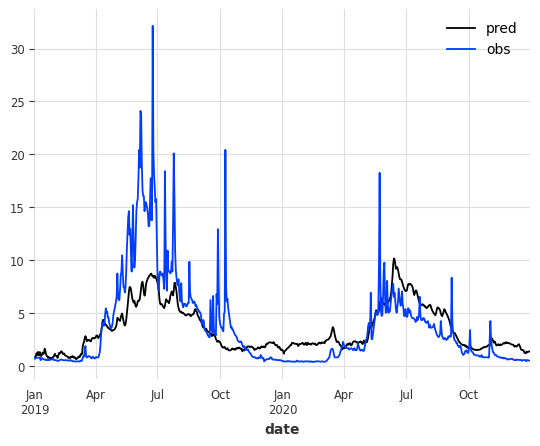

In [48]:
pred_df_multi.plot()
metric_res_df

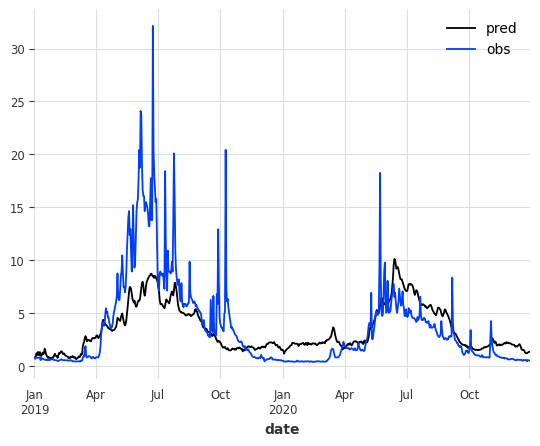

In [32]:
pred_df = reduce(lambda df1, df2: df2.combine_first(df1), test_pred)
pred_df = pred_df.rename(columns={f"{hydro_target}": "pred"})
pred_df["obs"] = target_obs.values[:-1]
metric_df(gauge_id=gauge_id, predictions=pred_df["pred"], targets=pred_df["obs"])
pred_df.plot();

,NSE,KGE,r,alpha,beta,RMSE,delta
83262,-0.064271,0.060633,0.266214,1.584396,0.9505,4.394851,-134.048291


In [75]:
i = 0
pred_cov_past = pred_cov[0][-(pred_len + i) :]
pred_cov_future = pred_cov[0][
    -(pred_len + input_chunk_length + i) : -(
        pred_len - input_chunk_length - output_chunk_length - i
    )
]

some_pred = tft_model.predict(
    n=output_chunk_length,
    series=pred_target,
    past_covariates=pred_cov_past,
    future_covariates=pred_cov_future,
    verbose=False,
    num_loader_workers=15,
)

temp_df = pd.DataFrame()
temp_df = temp_df.set_index("date")
temp_df["date"] = some_pred[0].time_index
temp_df[f"{hydro_target}"] = (
    train_target_scaler.inverse_transform(some_pred[0]).values().squeeze()
)
temp_df.loc[:, [*static_parameters]] = np.NaN


merging_df = pred_period.set_index("date")
merging_df.index = pd.to_datetime(merging_df.index)

merging_df[[f"{hydro_target}"]] = merging_df[[f"{hydro_target}"]].combine_first(temp_df)

In [83]:
temp_df

,q_mm_day,for_pc_sse,crp_pc_sse,inu_pc_ult,ire_pc_sse,lka_pc_use,prm_pc_sse,pst_pc_sse,cly_pc_sav,slt_pc_sav,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,sgr_dk_sav,slp_dg_sav,ws_area,ele_mt_sav
date,,,,,,,,,,,,,,,,,,,,
2019-01-01,1.343204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,1.307710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,1.101017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2.052484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,1.426145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-06,2.123254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,1.889713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
merging_df.combine_first(temp_df)

date
2008-01-01    0.800198
2008-01-02    1.208668
2008-01-03    1.674055
2008-01-04    1.841461
2008-01-05    1.441362
                ...   
2019-01-03    1.101017
2019-01-04    2.052484
2019-01-05    1.426145
2019-01-06    2.123254
2019-01-07    1.889713
Name: q_mm_day, Length: 4025, dtype: float64

,q_mm_day
date,
2008-01-01,0.800198
2008-01-02,1.208668
2008-01-03,1.674055
2008-01-04,1.841461
2008-01-05,1.441362
...,...
2019-01-03,1.101017
2019-01-04,2.052484
2019-01-05,1.426145


In [68]:
pred_period.set_index("date")[[f"{hydro_target}"]].combine_first(some_pred)

TypeError: object of type 'builtin_function_or_method' has no len()

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07'],
              dtype='datetime64[ns]', name='date', freq='D')

In [ ]:

    pred_period = pd.date_range(start=pred_start, end=pred_end).__len__()

    pred_series = pred_target[0][: (-pred_period + input_chunk_length)]
    for i in range(
        0, pred_period - input_chunk_length - output_chunk_length, output_chunk_length
    ):
        pred_cov_past = pred_cov[0][-(pred_period + i) :]
        pred_cov_future = pred_cov[0][
            -(pred_period + input_chunk_length + i) : -(
                pred_period - input_chunk_length - output_chunk_length - i
            )
        ]

        some_pred = tft_model.predict(
            n=output_chunk_length,
            series=pred_series,
            past_covariates=pred_cov_past,
            future_covariates=pred_cov_future,
            verbose=False,
            num_loader_workers=15,
        )
        pred_series = pred_series.append(some_pred)

    test_df = pd.DataFrame()
    test_df["obs"] = (
        train_target_scaler.inverse_transform(
            pred_target[0][-(pred_period - input_chunk_length) :]
        )
        .values()
        .squeeze()
    )
    test_df["pred"] = (
        train_target_scaler.inverse_transform(
            pred_series[-(pred_period - input_chunk_length) :]
        )
        .values()
        .squeeze()
    )
    tft_single_gauge_stat.append(
        metric_df(
            gauge_id=gauge_id, predictions=test_df["pred"], targets=test_df["obs"]
        )
    )

,NSE,KGE,r,alpha,beta,RMSE,delta
4107,-0.010824,0.223573,0.403474,1.380426,0.680201,3.557369,-134.354935


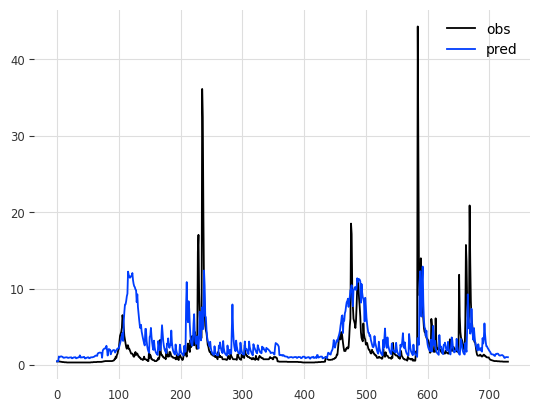

In [220]:
test_df.plot()
tft_single_gauge_stat[0]

In [ ]:
test_df = list()

for i in range(
    pd.date_range(start=pred_start, end=pred_end).__len__()
    - (input_chunk_length + output_chunk_length),
    -1,
    -1,
):
    some_pred = tft_model.predict(
        n=output_chunk_length,
        series=pred_target[0][: -(output_chunk_length + i)],
        past_covariates=pred_cov[0][: -(output_chunk_length + i)],
        future_covariates=pred_cov[0][
            -(input_chunk_length + output_chunk_length + i) :
        ],
        verbose=False,
        num_loader_workers=15,
    )
    pred_df = pd.DataFrame()
    pred_df.index = some_pred.time_index
    pred_df["pred"] = (
        train_target_scaler.inverse_transform(some_pred).values().squeeze()
    )
    test_df.append(pred_df)

test_df = reduce(lambda df1, df2: df2.combine_first(df1), test_df)
test_df["obs"] = (
    train_target_scaler.inverse_transform(pred_target[0])[input_chunk_length:]
    .values()
    .squeeze()
)

# res_df[["pred", "obs"]].plot()
tft_single_gauge_stat.append(
    metric_df(gauge_id=gauge_id, predictions=test_df["pred"], targets=test_df["obs"])
)

In [14]:
pred_cov

<TimeSeries (DataArray) (date: 1096, component: 3, sample: 1)> Size: 13kB
array([[[-0.3143035 ],
        [-0.7569961 ],
        [-0.5647503 ]],

       [[-0.01383902],
        [-0.8156107 ],
        [-0.7067473 ]],

       [[-0.37059513],
        [-1.0675361 ],
        [-1.0421956 ]],

       ...,

       [[-0.20723854],
        [-1.978397  ],
        [-1.7885166 ]],

       [[-0.14608859],
        [-1.7598221 ],
        [-1.7780948 ]],

       [[ 0.19019769],
        [-1.5742632 ],
        [-1.3624568 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 9kB 2018-01-01 2018-01-02 ... 2020-12-31
  * component  (component) object 24B 'prcp_e5l' 't_max_e5l' 't_min_e5l'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  gauge_id  for_pc_sse  crp_pc_sse  ...
    hierarchy:          None

In [12]:
pred_target[0]

<TimeSeries (DataArray) (date: 1096, component: 1, sample: 1)> Size: 4kB
array([[[-0.28177828]],

       [[-0.29452035]],

       [[-0.30726242]],

       ...,

       [[-0.49202248]],

       [[-0.49202248]],

       [[-0.49202248]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 9kB 2018-01-01 2018-01-02 ... 2020-12-31
  * component  (component) object 8B 'q_mm_day'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  gauge_id  for_pc_sse  crp_pc_sse  ...
    hierarchy:          None

In [ ]:
from tqdm.notebook import tqdm

tft_single_gauge_stat = list()

for gauge_id in tqdm(gauges, desc="I'm Scatman !"):
    tft_model = TFTModel.load_from_checkpoint(
        model_name="q_mm_day_hs256_bs256_do042",
        work_dir=f"./model/single_gauge/{gauge_id}",
    )

    if isinstance(static_attributes, pd.DataFrame):
        static_attributes = static_attributes[[*static_parameters]]
        gauge_static = static_attributes.loc[[gauge_id], :]
    else:
        gauge_static = None
    with xr.open_dataset(
        f"../geo_data/ws_related_meteo/{nc_variable}/{gauge_id}.nc"
    ) as f:
        gauge_file = f.to_dataframe()
    gauge_file = gauge_file[[*meteo_input, hydro_target, "gauge_id"]]

    if isinstance(gauge_static, pd.DataFrame):
        for col in gauge_static.columns:
            gauge_file[col] = gauge_static.loc[gauge_id, col]

    past_df = gauge_file[:train_end].reset_index(drop=False)
    future_df = gauge_file[:val_end].reset_index(drop=False)
    val_past_df = gauge_file[val_start:val_end].reset_index(drop=False)
    val_future_df = gauge_file[val_start:val_end].reset_index(drop=False)
    pred_df = gauge_file[pred_start:pred_end].reset_index(drop=False)

    # create timeseries and scaler
    train_target_scaler, train_cov_scaler, train_static_scaler = (
        Scaler(scaler=StandardScaler()),
        Scaler(scaler=StandardScaler()),
        StaticCovariatesTransformer(),
    )
    # train
    train_target = target_creator(
        data_frame=past_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    past_cov = covariate_creator(
        data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
    )
    future_cov = covariate_creator(
        data_frame=future_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    # val
    val_target = target_creator(
        data_frame=val_past_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    # val_plot = target_creator(
    #     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
    val_past_cov = covariate_creator(
        data_frame=val_past_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    val_future_cov = covariate_creator(
        data_frame=val_future_df,
        static_parameters=static_parameters,
        meteo_input=meteo_input,
    )
    # pred
    pred_target = target_creator(
        data_frame=pred_df,
        target_input=hydro_target,
        static_parameters=static_parameters,
    )
    pred_cov = covariate_creator(
        data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
    )

    def type32_converter(
        series_list: TimeSeries | list[TimeSeries],
    ) -> list[TimeSeries]:
        return [s.astype(dtype="float32") for s in series_list]

    def scale_with_static(
        series: TimeSeries | list[TimeSeries],
        scaler: Scaler,
        static_scaler: StaticCovariatesTransformer,
    ) -> list[TimeSeries]:
        series = scaler.transform(series=series)
        series = static_scaler.transform(series=series)

        return type32_converter(series_list=series)

    # scale target
    train_target = train_target_scaler.fit_transform(train_target)
    train_target = train_static_scaler.fit_transform(train_target)
    train_target = type32_converter(train_target)
    # scale covariate
    past_cov = train_cov_scaler.fit_transform(past_cov)
    past_cov = train_static_scaler.transform(past_cov)
    past_cov = type32_converter(past_cov)
    # prepare new data
    future_cov = scale_with_static(
        series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )
    # val
    val_target = scale_with_static(
        series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
    )
    val_past_cov = scale_with_static(
        series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )
    val_future_cov = scale_with_static(
        series=val_future_cov,
        scaler=train_cov_scaler,
        static_scaler=train_static_scaler,
    )
    # pred
    pred_target = scale_with_static(
        series=pred_target,
        scaler=train_target_scaler,
        static_scaler=train_static_scaler,
    )
    pred_cov = scale_with_static(
        series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
    )

    test_df = list()

    for i in range(
        pd.date_range(start=pred_start, end=pred_end).__len__()
        - (input_chunk_length + output_chunk_length),
        -1,
        -1,
    ):
        some_pred = tft_model.predict(
            n=output_chunk_length,
            series=pred_target[0][: -(output_chunk_length + i)],
            past_covariates=pred_cov[0][: -(output_chunk_length + i)],
            future_covariates=pred_cov[0][
                -(input_chunk_length + output_chunk_length + i) :
            ],
            verbose=False,
            num_loader_workers=15,
        )
        pred_df = pd.DataFrame()
        pred_df.index = some_pred.time_index
        pred_df["pred"] = (
            train_target_scaler.inverse_transform(some_pred).values().squeeze()
        )
        test_df.append(pred_df)

    test_df = reduce(lambda df1, df2: df2.combine_first(df1), test_df)
    test_df["obs"] = (
        train_target_scaler.inverse_transform(pred_target[0])[input_chunk_length:]
        .values()
        .squeeze()
    )

    # res_df[["pred", "obs"]].plot()
    tft_single_gauge_stat.append(
        metric_df(
            gauge_id=gauge_id, predictions=test_df["pred"], targets=test_df["obs"]
        )
    )

In [24]:
tft_model = TFTModel.load_from_checkpoint(
    model_name="q_mm_day_hs256_bs256_do042",
    work_dir=f"./model/single_gauge/{gauge_id}",
)

if isinstance(static_attributes, pd.DataFrame):
    static_attributes = static_attributes[[*static_parameters]]
    gauge_static = static_attributes.loc[[gauge_id], :]
else:
    gauge_static = None
with xr.open_dataset(f"../geo_data/ws_related_meteo/{nc_variable}/{gauge_id}.nc") as f:
    gauge_file = f.to_dataframe()
gauge_file = gauge_file[[*meteo_input, hydro_target, "gauge_id"]]

if isinstance(gauge_static, pd.DataFrame):
    for col in gauge_static.columns:
        gauge_file[col] = gauge_static.loc[gauge_id, col]

past_df = gauge_file[:train_end].reset_index(drop=False)
future_df = gauge_file[:val_end].reset_index(drop=False)
val_past_df = gauge_file[val_start:val_end].reset_index(drop=False)
val_future_df = gauge_file[val_start:val_end].reset_index(drop=False)
pred_df = gauge_file[pred_start:pred_end].reset_index(drop=False)

# create timeseries and scaler
train_target_scaler, train_cov_scaler, train_static_scaler = (
    Scaler(scaler=StandardScaler()),
    Scaler(scaler=StandardScaler()),
    StaticCovariatesTransformer(),
)
# train
train_target = target_creator(
    data_frame=past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
past_cov = covariate_creator(
    data_frame=past_df, static_parameters=static_parameters, meteo_input=meteo_input
)
future_cov = covariate_creator(
    data_frame=future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# val
val_target = target_creator(
    data_frame=val_past_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
# val_plot = target_creator(
#     data_frame=plot_val_df, target_input=hydro_target, static_parameters=static_parameters)
val_past_cov = covariate_creator(
    data_frame=val_past_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
val_future_cov = covariate_creator(
    data_frame=val_future_df,
    static_parameters=static_parameters,
    meteo_input=meteo_input,
)
# pred
pred_target = target_creator(
    data_frame=pred_df,
    target_input=hydro_target,
    static_parameters=static_parameters,
)
pred_cov = covariate_creator(
    data_frame=pred_df, static_parameters=static_parameters, meteo_input=meteo_input
)


def type32_converter(
    series_list: TimeSeries | list[TimeSeries],
) -> list[TimeSeries]:
    return [s.astype(dtype="float32") for s in series_list]


def scale_with_static(
    series: TimeSeries | list[TimeSeries],
    scaler: Scaler,
    static_scaler: StaticCovariatesTransformer,
) -> list[TimeSeries]:
    series = scaler.transform(series=series)
    series = static_scaler.transform(series=series)

    return type32_converter(series_list=series)


# scale target
train_target = train_target_scaler.fit_transform(train_target)
train_target = train_static_scaler.fit_transform(train_target)
train_target = type32_converter(train_target)
# scale covariate
past_cov = train_cov_scaler.fit_transform(past_cov)
past_cov = train_static_scaler.transform(past_cov)
past_cov = type32_converter(past_cov)
# prepare new data
future_cov = scale_with_static(
    series=future_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
# val
val_target = scale_with_static(
    series=val_target, scaler=train_target_scaler, static_scaler=train_static_scaler
)
val_past_cov = scale_with_static(
    series=val_past_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)
val_future_cov = scale_with_static(
    series=val_future_cov,
    scaler=train_cov_scaler,
    static_scaler=train_static_scaler,
)
# pred
pred_target = scale_with_static(
    series=pred_target,
    scaler=train_target_scaler,
    static_scaler=train_static_scaler,
)
pred_cov = scale_with_static(
    series=pred_cov, scaler=train_cov_scaler, static_scaler=train_static_scaler
)

In [ ]:
test_df = list()

for i in range(
    pd.date_range(start=pred_start, end=pred_end).__len__()
    - (input_chunk_length + output_chunk_length),
    -1,
    -1,
):
    some_pred = tft_model.predict(
        n=output_chunk_length,
        series=pred_target[0][: -(output_chunk_length + i)],
        past_covariates=pred_cov[0][: -(output_chunk_length + i)],
        future_covariates=pred_cov[0][
            -(input_chunk_length + output_chunk_length + i) :
        ],
        verbose=False,
        num_loader_workers=15,
    )
    pred_df = pd.DataFrame()
    pred_df.index = some_pred.time_index
    pred_df["pred"] = (
        train_target_scaler.inverse_transform(some_pred).values().squeeze()
    )
    test_df.append(pred_df)

test_df = reduce(lambda df1, df2: df2.combine_first(df1), test_df)
test_df["obs"] = (
    train_target_scaler.inverse_transform(pred_target[0])[input_chunk_length:]
    .values()
    .squeeze()
)

# res_df[["pred", "obs"]].plot()

tft_model = None
metric_df(gauge_id=gauge_id, predictions=test_df["pred"], targets=test_df["obs"])

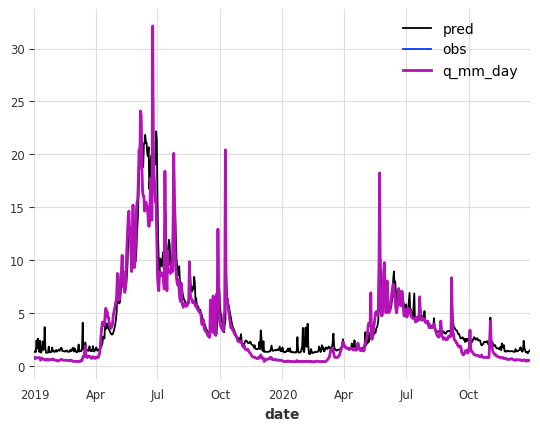

In [26]:
test_df[["pred", "obs"]].plot(legend=True)
train_target_scaler.inverse_transform(pred_target[0])[input_chunk_length:].plot();

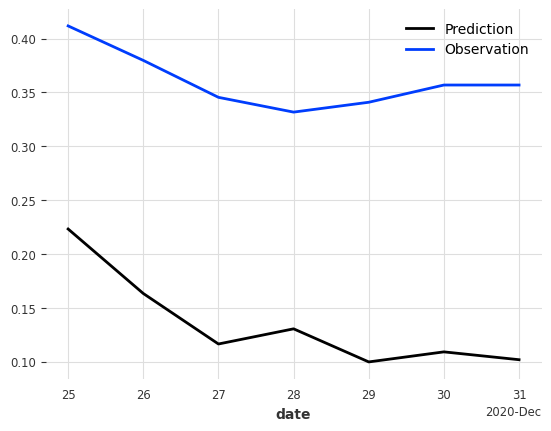

In [135]:
train_target_scaler.inverse_transform(some_pred).plot(label="Prediction")
train_target_scaler.inverse_transform(pred_target[0][-output_chunk_length:]).plot(
    label="Observation"
);